## Step 1 : Import libraries

In [21]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Import File

In [57]:
filepath = r"C:\Users\welde\Documents\GitHub\AI-project\model\preprocessed_data\processed_train_en.tsv"
df = pd.read_csv(filepath, sep='\t')

## Step 3: Check about the dataframe
    

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentence_id      830 non-null    object
 1   label            830 non-null    object
 2   solved_conflict  830 non-null    bool  
 3   sentence         830 non-null    object
dtypes: bool(1), object(3)
memory usage: 20.4+ KB


# word frequency plot

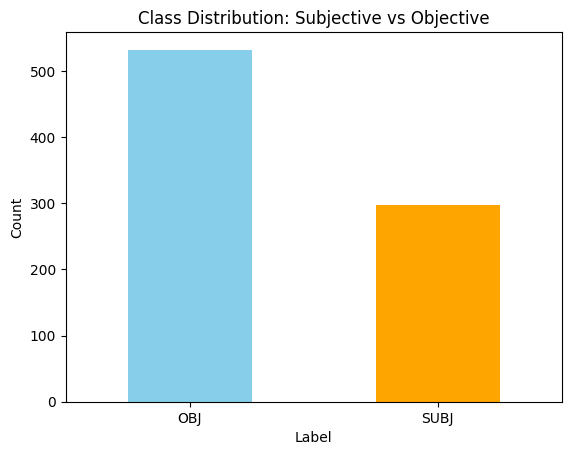

In [27]:
import matplotlib.pyplot as plt

# Count the number of SUBJ and OBJ
class_counts = df['label'].value_counts()

# Plot
class_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution: Subjective vs Objective')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


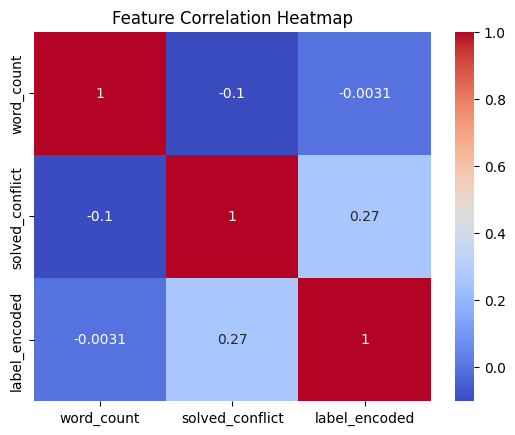

In [ ]:


# Encode label column as 0 (OBJ) and 1 (SUBJ)
df['label_encoded'] = df['label'].apply(lambda x: 1 if x == 'SUBJ' else 0)

# Select numerical columns for correlation
correlation_matrix = df[['word_count', 'solved_conflict', 'label_encoded']].corr()

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


In [60]:
import ast

# Convert the string representation of lists into actual lists
df['sentence'] = df['sentence'].apply(ast.literal_eval)

# Verify the conversion
print(type(df['sentence'].iloc[0]))  # Should now print <class 'list'>
print(df['sentence'].iloc[0])       # Should print ['go', 'day', 'lead', 'world', 'recessionbuster']


<class 'list'>
['go', 'day', 'lead', 'world', 'recessionbuste']


## TF-IDF Vectorization

c:\Users\welde\miniconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


            Word      Score
1302  government  22.178370
2764       state  13.441971
3211        year  11.165693
1947         new  10.937593
2307      public  10.457957
2555         say  10.089686
2877     teacher   9.543416
1700        like   8.002747
687         cost   8.002593
1475    increase   7.923875


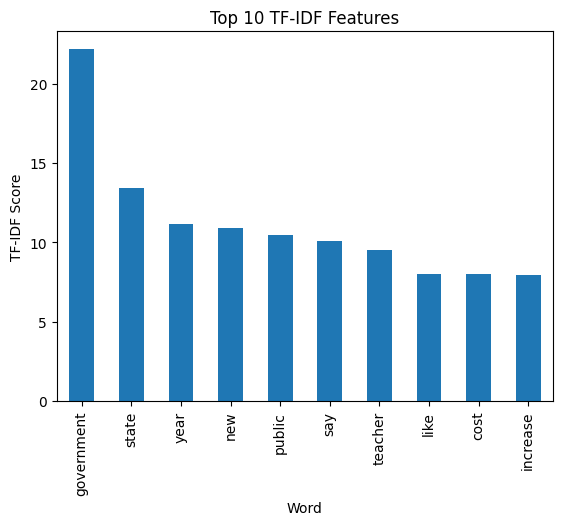

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt

# Define an identity tokenizer for pre-tokenized input
def identity_tokenizer(text):
    return text

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    tokenizer=identity_tokenizer,  # Use the pre-tokenized input
    lowercase=False,               # Data is already clean
    stop_words=None                # Stop words are already handled
)

# Fit and transform the tokenized data
X_tfidf = tfidf.fit_transform(df['sentence'])

# Extract and visualize TF-IDF scores
tfidf_scores = pd.DataFrame({
    'Word': tfidf.get_feature_names_out(),
    'Score': X_tfidf.toarray().sum(axis=0)
})

# Sort and display the top words
top_words = tfidf_scores.sort_values(by='Score', ascending=False).head(10)
print(top_words)

# Plot the results
top_words.plot(kind='bar', x='Word', y='Score', legend=False)
plt.title('Top 10 TF-IDF Features')
plt.ylabel('TF-IDF Score')
plt.xlabel('Word')
plt.show()


# most frequent words 

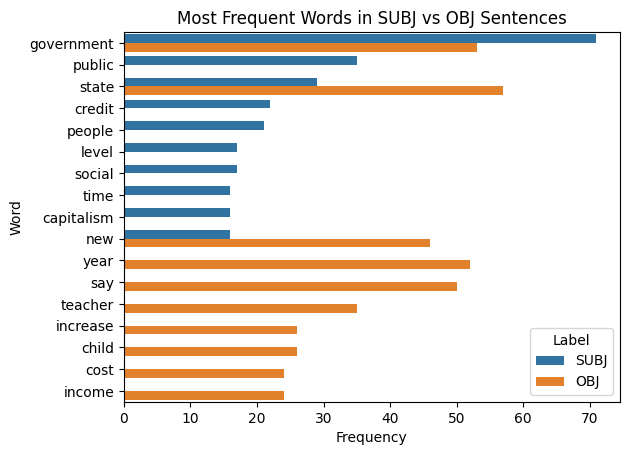

In [62]:
from collections import Counter
import pandas as pd

# Extract tokens from SUBJ and OBJ
subj_words = [word for tokens in df[df['label'] == 'SUBJ']['sentence'] for word in tokens]
obj_words = [word for tokens in df[df['label'] == 'OBJ']['sentence'] for word in tokens]

# Count top 10 words
subj_word_counts = Counter(subj_words).most_common(10)
obj_word_counts = Counter(obj_words).most_common(10)

# Create DataFrame for plotting
word_freq_df = pd.DataFrame({
    'Word': [x[0] for x in subj_word_counts + obj_word_counts],
    'Frequency': [x[1] for x in subj_word_counts + obj_word_counts],
    'Label': ['SUBJ'] * len(subj_word_counts) + ['OBJ'] * len(obj_word_counts)
})

# Plot
import seaborn as sns
sns.barplot(data=word_freq_df, x='Frequency', y='Word', hue='Label')
plt.title('Most Frequent Words in SUBJ vs OBJ Sentences')
plt.show()


# Topic Modeling

In [66]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# Apply Latent Dirichlet Allocation (LDA) to find topics
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust n_components for more topics
lda.fit(X_tfidf)

# Display the top words per topic
num_top_words = 10
feature_names = tfidf.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))


Topic #1:
unhappy teacher government money public work capitalism level want people
Topic #2:
new year state say law country course illegal alien power
Topic #3:
income government national rise tax increase cost absorb public state
Topic #4:
government cost state federal time increase taxis new reduce city
Topic #5:
government go way suppose state think child year public variant


# word pair analysis

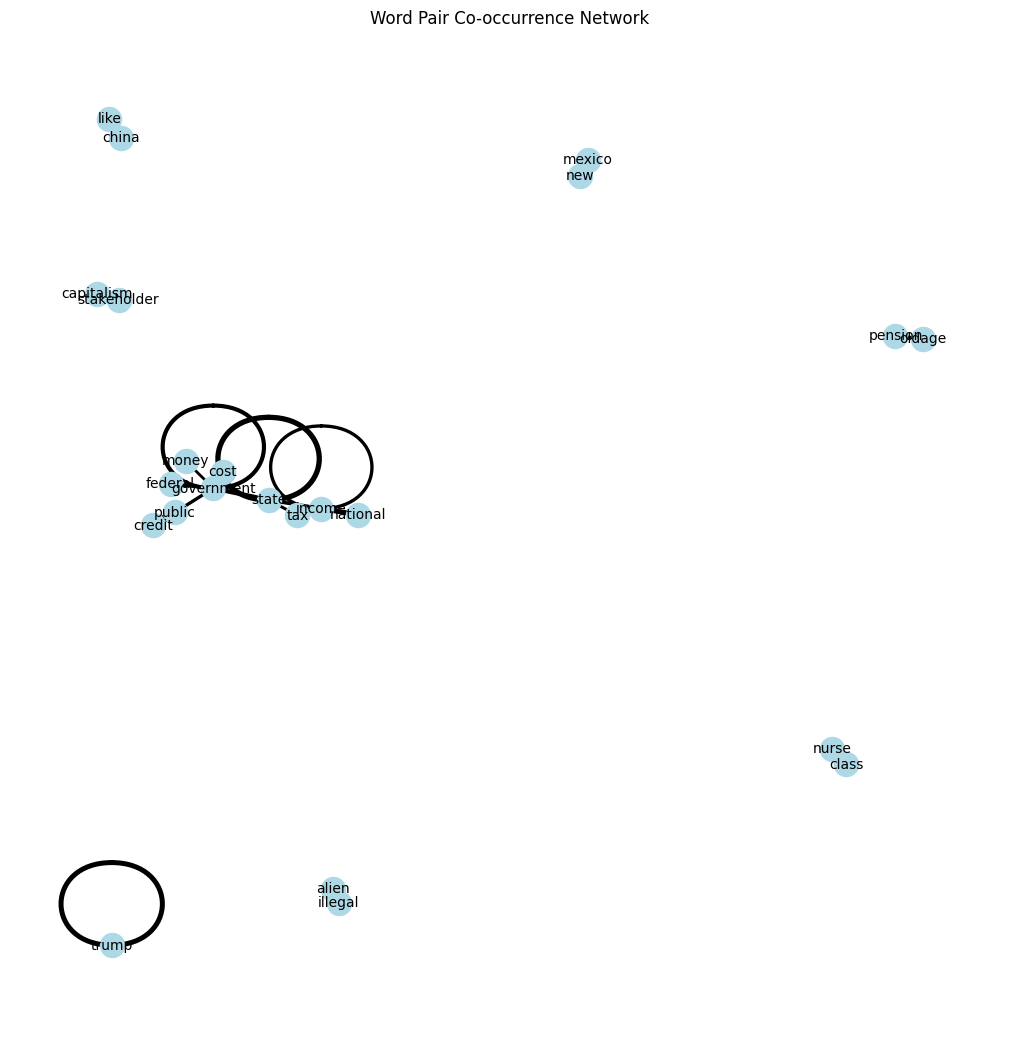

In [67]:
from collections import Counter
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

# Extract word pairs for each sentence
word_pairs = []
for sentence in df['sentence']:
    word_pairs.extend(combinations(sentence, 2))

# Count word pair frequencies
pair_counts = Counter(word_pairs).most_common(20)

# Create a network graph of word pairs
graph = nx.Graph()
for (word1, word2), count in pair_counts:
    graph.add_edge(word1, word2, weight=count)

# Plot the graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_color="lightblue", font_size=10, width=[d['weight'] / 5 for _, _, d in graph.edges(data=True)])
plt.title("Word Pair Co-occurrence Network")
plt.show()


3. Embedding Analysis (Word2Vec or Sentence Embeddings)
Use word embeddings (e.g., Word2Vec, GloVe, or Sentence Transformers) to capture semantic relationships between words or sentences. Then, cluster or visualize these embeddings to understand patterns.

In [68]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from gensim.models import Word2Vec

# Train Word2Vec on your sentences
model = Word2Vec(sentences=df['sentence'], vector_size=100, window=5, min_count=1, workers=4)

# Extract word embeddings
words = list(model.wv.index_to_key)
word_vectors = model.wv[words]

# Reduce dimensionality for visualization (using t-SNE)
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(word_vectors)

# Plot the word embeddings
plt.figure(figsize=(12, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.6)
for i, word in enumerate(words):
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], word, fontsize=9)
plt.title("Word Embeddings Visualization")
plt.show()


ModuleNotFoundError: No module named 'gensim'

# sentiment distribution

In [ ]:

from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Add sentiment scores for each sentence
df['sentiment'] = df['sentence'].apply(lambda x: sia.polarity_scores(" ".join(x))['compound'])

# Plot sentiment distribution
import seaborn as sns
sns.histplot(df, x='sentiment', hue='label', kde=True)
plt.title("Sentiment Distribution by Label")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()


LookupError: 
**********************************************************************
  Resource [93mvader_lexicon[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('vader_lexicon')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93msentiment/vader_lexicon.zip/vader_lexicon/vader_lexicon.txt[0m

  Searched in:
    - 'C:\\Users\\welde/nltk_data'
    - 'c:\\Users\\welde\\miniconda3\\nltk_data'
    - 'c:\\Users\\welde\\miniconda3\\share\\nltk_data'
    - 'c:\\Users\\welde\\miniconda3\\lib\\nltk_data'
    - 'C:\\Users\\welde\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - 'C:/Users/welde/AppData/Roaming/nltk_data'
    - ''
**********************************************************************


5. Cluster Sentences by Meaning

In [70]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Perform clustering on TF-IDF features
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(X_tfidf)

# Add cluster labels to DataFrame
df['cluster'] = labels

# Analyze clusters
for cluster_num in range(num_clusters):
    print(f"\nCluster {cluster_num}:")
    print(df[df['cluster'] == cluster_num]['sentence'].head(10))



Cluster 0:
16     [democrats, congress, try, ban, alien, illegal...
27     [state, sixtytwo, county, city, addition, 932,...
58     [white, house, mainstream, medium, try, avoid,...
61     [journalist, try, cle, remnant, professional, ...
62     [usually, politician, use, open, newspeaktype,...
74     [regard, tyranny, extreme, minority, try, impo...
102    [illegalalien, lawyer, allow, try, prevent, fe...
182    [result, medium, free, free, try, guess, audie...
222    [regulator, say, lab, animal, study, evidence,...
237                     [monkeypox, go, cause, lockdown]
Name: sentence, dtype: object

Cluster 1:
4                       [government, government, money]
10    [consolidate, power, hand, government, expect,...
32    [government, equality, level, look, opposite, ...
46    [federal, expenditure, rise, cost, government,...
60    [day, city, council, adopt, resolution, call, ...
63    [capita, cost, government, increase, follow, 1...
65    [tolerate, give, encouragement, ev

7. Part-of-Speech (POS) Analysis
Examine the usage of different parts of speech (e.g., nouns, verbs, adjectives) in subjective vs. objective sentences.

In [71]:
import nltk

# Tag each sentence with POS
df['pos_tags'] = df['sentence'].apply(lambda x: nltk.pos_tag(x))

# Count POS frequencies
from collections import Counter
subj_pos = Counter(tag for sentence in df[df['label'] == 'SUBJ']['pos_tags'] for _, tag in sentence)
obj_pos = Counter(tag for sentence in df[df['label'] == 'OBJ']['pos_tags'] for _, tag in sentence)

print("Top POS Tags in Subjective Sentences:")
print(subj_pos.most_common(10))
print("\nTop POS Tags in Objective Sentences:")
print(obj_pos.most_common(10))


LookupError: 
**********************************************************************
  Resource [93maveraged_perceptron_tagger_eng[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtaggers/averaged_perceptron_tagger_eng/[0m

  Searched in:
    - 'C:\\Users\\welde/nltk_data'
    - 'c:\\Users\\welde\\miniconda3\\nltk_data'
    - 'c:\\Users\\welde\\miniconda3\\share\\nltk_data'
    - 'c:\\Users\\welde\\miniconda3\\lib\\nltk_data'
    - 'C:\\Users\\welde\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - 'C:/Users/welde/AppData/Roaming/nltk_data'
**********************************************************************
